# Contamination Detection via Context (CoDeC)

This notebook shows how to use and understand **CoDeC** - a simple data contamination detection method for LLMs. The method compares the confidence of a model in predicting target text with and without similar context, identifying potentially contaminated data when the model shows higher confidence without context.

Read the full paper here: [https://www.arxiv.org/abs/2510.27055](https://www.arxiv.org/abs/2510.27055)

## Method Description

CoDeC works by comparing how well a language model predicts a target text in two scenarios:

1. **Without context**: The model sees only the target text
2. **With context**: The model sees other samples from the same dataset before the target text

### Key Intuition

If a dataset was seen during training (contaminated), the model should not benefit from the context, as it is already familiar with that distribution. However, if the target dataset is novel, providing other examples as context gives the model helpful information, making it more confident.

Therefore:
- **Higher confidence without context** → Likely contaminated
- **Higher confidence with context** → Likely not contaminated

### Algorithm Steps

1. For each sample in the dataset:
   - Get log probabilities for the sample alone
   - Get log probabilities for the sample with context examples
   - Compare average confidence scores
   - Classify as contaminated if confidence is higher without context

2. Calculate overall contamination score as the proportion of samples classified as contaminated

### Parameters

- **num_context_examples**: How many examples to use as context. In our experiments, we found that 1 is sufficient.
- **model_name**: HuggingFace model identifier.

### Data Loading Options

- **Pickle files (.pkl)**: It is expected to contain a list of strings
- **Text files (.txt)**: It will be automatically split into chunks
- **Benchmark datasets**: Download a benchmark dataset from the HuggingFace.

This method is simple, interpretable, and requires only the model's log probabilities. Hence, it can be easily applied to any model and dataset, as you can see below.

# Setup

In [ ]:
import os
import pickle
import random
import re
from collections import defaultdict
from typing import Any, Dict, List

import numpy as np
import pandas as pd
import torch
from datasets import Dataset, load_dataset
from matplotlib import pyplot as plt
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

# Core Implementation of CoDeC

The contamination detection pipeline consists of three main components:
1. **Model Handler**: Loads and manages the language model
2. **Contamination Detector**: Implements the core detection algorithm
3. **Pipeline**: Orchestrates the detection process for a dataset


In [2]:
class ModelHandler:
    """Handles model loading and inference for contamination detection."""

    def __init__(
        self,
        model_name: str,
        device: str = "auto",
        verbose=False,
        model_revision=None,
        checkpoint_path=None,
    ):
        self.model_name = model_name
        if device == "auto":
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        if verbose:
            print(f"Loading model {model_name} on {self.device}...")

        if checkpoint_path is None:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                revision=model_revision,
                torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
            ).to(self.device)
        else:
            self.load_from_checkpoint(checkpoint_path)

        # Add padding token if not present
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        if verbose:
            print("Model loaded successfully!")

    def load_from_checkpoint(self, checkpoint_path):
        self.model = AutoModelForCausalLM.from_pretrained(checkpoint_path).to(
            self.device
        )
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

    def get_logprobs(self, text: str) -> np.ndarray:
        """Get log probabilities for each token in the text."""

        with torch.no_grad():
            # Tokenize input
            inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

            # Get model outputs
            outputs = self.model(**inputs)
            logits = outputs.logits

            # Convert logits to log probabilities
            log_probs = torch.log_softmax(logits, dim=-1)

            # Get the log probability of each actual token
            input_ids = inputs["input_ids"][0]
            token_log_probs = []

            for i in range(len(input_ids) - 1):
                next_token_id = input_ids[i + 1]
                token_log_prob = log_probs[0, i, next_token_id].item()
                token_log_probs.append(token_log_prob)

            return np.array(token_log_probs)

In [ ]:
class CoDeC:
    """Detects data contamination using in-context learning differences."""

    def __init__(self, token_range: tuple = (10, -1)):
        """
        Initialize the contamination detector.

        Args:
            token_range: Range of tokens to consider for contamination detection.
        """
        self.token_range = token_range

    def detect_contamination(
        self, target_text: str, context_examples: List[str], model_handler: ModelHandler
    ) -> float:
        """
        Detect contamination for a single target text.

        Args:
            target_text: The text to test for contamination
            context_examples: List of examples to use as context
            model_handler: Model handler for inference

        Returns:
            Contamination score (1 = contaminated, 0 = not contaminated)
        """
        # Get log probabilities without context
        logprobs_no_context = model_handler.get_logprobs(target_text)

        # Create context by joining examples
        if context_examples:
            context = "\n\n".join(context_examples)
            text_with_context = context + "\n\n" + target_text
        else:
            text_with_context = target_text

        # Get log probabilities with context
        logprobs_with_context = model_handler.get_logprobs(text_with_context)

        # Extract target portion from context output
        # The target text appears at the end, so we take the last N tokens
        target_tokens_no_context = len(logprobs_no_context)
        logprobs_target_from_context = logprobs_with_context[-target_tokens_no_context:]

        # Calculate average confidence for the specified token range
        start_idx, end_idx = self.token_range
        end_idx = min(end_idx, len(logprobs_no_context))

        if start_idx >= len(logprobs_no_context) - 1:
            # Target text is too short
            print(f"Target text is too short: {target_text}")
            return None

        # Average confidence without context
        confidence_no_context = np.mean(logprobs_no_context[start_idx:end_idx])

        # Average confidence with context
        confidence_with_context = np.mean(
            logprobs_target_from_context[start_idx:end_idx]
        )

        # Calculate difference (higher confidence without context suggests contamination)
        confidence_diff = confidence_no_context - confidence_with_context

        # Return binary classification (1 if contaminated, 0 if not)
        return 1.0 if confidence_diff > 0 else 0.0

In [4]:
def contamination_detection_pipeline(
    model: str | ModelHandler,
    dataset: List[str],
    num_context_examples: int = 1,
    max_dataset_size: int = 1000,
    max_sample_length: int = 2048,
    seed: int = 42,
) -> Dict[str, Any]:
    """
    Run contamination detection on a dataset.

    Args:
        model: HuggingFace model name/checkpoint, or ModelHandler instance
        dataset: List of text samples to test
        num_context_examples: Number of context examples to use
        max_dataset_size: Maximum number of samples to process
        max_sample_length: Maximum length of a sample
        seed: Random seed for reproducibility

    Returns:
        Dictionary with contamination scores and overall score
    """
    random.seed(seed)
    np.random.seed(seed)

    # Initialize components
    if isinstance(model, str):
        model_handler = ModelHandler(model)
    else:
        model_handler = model
    detector = CoDeC()

    if max_sample_length is not None:

        def trim_sample(sample):
            if len(sample) > max_sample_length:
                sample = sample[:max_sample_length]
                sample = " ".join(sample.split(" ")[:-1])

            return sample

        dataset = [trim_sample(sample) for sample in dataset]

    if max_dataset_size is not None:
        if len(dataset) > max_dataset_size:
            dataset = random.sample(dataset, max_dataset_size)

    print(f"Processing {len(dataset)} samples...")

    # Process each sample
    sample_scores = []

    for i, target_text in enumerate(dataset):
        # Select context examples (excluding current sample)
        available_examples = dataset[:i] + dataset[i + 1 :]

        if len(available_examples) >= num_context_examples:
            # Randomly sample context examples
            context_examples = random.sample(available_examples, num_context_examples)
        else:
            # Use all available examples if not enough
            context_examples = available_examples

        # Detect contamination for this sample
        score = detector.detect_contamination(
            target_text, context_examples, model_handler
        )
        if score is not None:
            sample_scores.append(score)

    # Calculate overall contamination score
    overall_score = np.mean(sample_scores)

    return {
        "model_name": model_handler.model_name,
        "overall_contamination_score": overall_score,
        "sample_scores": sample_scores,
        "num_samples": len(dataset),
        "num_contaminated": sum(sample_scores),
    }

# Data Loading Utilities

In [5]:
def load_dataset_from_pkl(file_path: str) -> List[str]:
    """
    Load a dataset from a pickle file containing a list of strings.

    Args:
        file_path: Path to the .pkl file

    Returns:
        List of text samples
    """
    try:
        with open(file_path, "rb") as f:
            dataset = pickle.load(f)

        # Ensure dataset is a list of strings
        if not isinstance(dataset, list):
            raise ValueError(f"Expected list in pickle file, got {type(dataset)}")

        # Convert all items to strings if they aren't already
        dataset = [str(item) for item in dataset]

        print(f"Loaded {len(dataset)} samples from {file_path}")
        return dataset

    except Exception as e:
        print(f"Error loading pickle file {file_path}: {e}")
        raise


def load_dataset_from_txt(
    file_path: str, chunk_size: int = 500, min_chunk_size: int = 100
) -> List[str]:
    """
    Load a dataset from a text file by splitting it into chunks.

    Args:
        file_path: Path to the .txt file
        chunk_size: Approximate number of characters per chunk
        min_chunk_size: Minimum chunk size (chunks smaller than this are discarded)

    Returns:
        List of text chunks
    """
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

            chunks = []

            while len(text) > chunk_size:
                sample = text[:chunk_size]

                # Remove the boundary words that may have been cut off
                sample = " ".join(sample.split(" ")[1:-1])

                # Only add chunks that are larger than the minimum chunk size
                if len(sample) > min_chunk_size:
                    chunks.append(sample.strip())

                text = text[chunk_size:]

        print(f"Split text file {file_path} into {len(chunks)} chunks")
        print(
            f"Average chunk size: {np.mean([len(chunk) for chunk in chunks]):.1f} characters"
        )

        return chunks

    except Exception as e:
        print(f"Error loading text file {file_path}: {e}")
        raise


def load_local_dataset(file_path: str, **kwargs) -> List[str]:
    """
    Load a dataset from a file, automatically detecting the format.

    Args:
        file_path: Path to the dataset file (.pkl or .txt)
        **kwargs: Additional arguments passed to format-specific loaders

    Returns:
        List of text samples
    """
    if file_path.endswith(".pkl"):
        return load_dataset_from_pkl(file_path)
    elif file_path.endswith(".txt"):
        return load_dataset_from_txt(file_path, **kwargs)
    else:
        raise ValueError(
            f"Unsupported file format. Expected .pkl or .txt, got: {file_path}"
        )

## Benchmarks

It is straightforward to evaluate the contamination detection pipeline on any benchmark. Here, we show how to evaluate it on GPQA and other benchmarks:

In [6]:
def load_gpqa_dataset():
    df = load_dataset("Idavidrein/gpqa", "gpqa_diamond")["train"].to_pandas()
    return df["Question"].tolist()


def load_gsm8k_dataset():
    df = load_dataset("openai/gsm8k", "main")["test"].to_pandas()
    return df["question"].tolist()


def load_aime_dataset(version="2024"):
    if version == "2025":
        df = pd.concat(
            [
                load_dataset(
                    "opencompass/AIME2025",
                    name="AIME2025-I",
                    split="test",
                    trust_remote_code=True,
                ).to_pandas(),
                load_dataset(
                    "opencompass/AIME2025",
                    name="AIME2025-II",
                    split="test",
                    trust_remote_code=True,
                ).to_pandas(),
            ]
        )
        return [row["question"] for _, row in df.iterrows()]
    elif version == "2024":
        df = load_dataset("AI-MO/aimo-validation-aime", trust_remote_code=True)[
            "train"
        ].to_pandas()
        return [row["problem"] for _, row in df.iterrows()]
    else:
        raise ValueError(f"Unknown AIME version: {version}")

## Training datasets

In [7]:
def load_pile_wikipedia_dataset():
    dataset = load_dataset("iamgroot42/mimir", "wikipedia_(en)", split="ngram_13_0.8")
    return dataset["member"]


def load_pile_github_dataset():
    dataset = load_dataset("iamgroot42/mimir", "github", split="ngram_13_0.8")
    return dataset["member"]

# Experiments

## Verify a model

How contaminated is your model? CoDeC scores on training datasets are close to 100%. In contrast, on unseen datasets (such as benchmarks or other recently created data) the scores are far lower, usually in the range 0%-50%.

Choose your model and data, and try it yourself!

For a meaningful evaluation:
- **Ensure that the training data is passed in the form used in the training of the model.** Changing the format, adding additional labels (such as "Question" or "Answer"), or heavy curation may negatively impact the estimates. CoDeC captures the contamination arising from training on related data as well, but the scores may be lower if the target dataset diverges from the training data.
- **Ensure that unseen data is indeed unseen.** Training corpora typically contain all sorts of data, and it is possible that some of it is similar to the target dataset, which may naturally result in higher scores.
- **Understand the relation to the training data.** For instance, books recently added to Project Gutenberg, while technically not seen by older models, are closely related to thousands of other books used for training, and thus the scores may be naturally higher. Adjust your expectations accordingly.

In [9]:
ID_datasets = [
    (load_pile_wikipedia_dataset(), "Pile Wikipedia"),
    (load_pile_github_dataset(), "Pile GitHub"),
]
OOD_datasets = [(load_gsm8k_dataset(), "GSM8K"), (load_gpqa_dataset(), "GPQA")]

data = [("Seen datasets", ID_datasets), ("Unseen datasets", OOD_datasets)]

model_handler = ModelHandler("EleutherAI/pythia-410m", verbose=True)

for name, datasets in data:
    print(f"\n{name}")
    for dataset, name in datasets:
        result = contamination_detection_pipeline(
            model_handler, dataset, num_context_examples=1, max_dataset_size=1000
        )
        print(
            f"CoDeC contamination score ({name}): {result['overall_contamination_score']}"
        )

Loading model EleutherAI/pythia-410m on cuda...
Model loaded successfully!

Seen datasets
Processing 1000 samples...
CoDeC contamination score (Pile Wikipedia): 0.963
Processing 1000 samples...
CoDeC contamination score (Pile GitHub): 0.882

Unseen datasets
Processing 1000 samples...
CoDeC contamination score (GSM8K): 0.057
Processing 198 samples...
CoDeC contamination score (GPQA): 0.398989898989899


## Verify a benchmark

How are different models contaminated with a given benchmark? Evaluate multiple ones and compare the CoDeC contamination scores.

For a meaningful evaluation:
- **The models should be similar in size.** Larger models naturally rely less on memorization, and thus exhibit lower contamination. While not a strict requirement, we recommend using models with similar sizes.
- **Use raw data from the benchmark.** If the benchmark is a QA dataset, we suggest not using the "Question" or "Answer" labels, but rather the raw data. If the labeling does not precisely match the model's training data, the scores may be much lower.
- **Prioritize parts more likely to be seen.** We found that models exhibit higher contamination on questions than answers or solutions. Usually focusing on questions is the best strategy.
- **Understand the results.** High CoDeC score is a sign of contamination, but a significant deviation from the distribution of other models is also alarming. More details can be found in Appendix A.5 of the paper.
- **Use a diverse set of models** to see the distribution of scores.

In [ ]:
def verify_benchmark(benchmark, models):
    results = []

    for model in models:
        model_handler = ModelHandler(model)
        result = contamination_detection_pipeline(
            model_handler, benchmark, num_context_examples=1, max_dataset_size=1000
        )
        print(
            f"CoDeC contamination score ({model}): {result['overall_contamination_score']}"
        )
        results.append((result["overall_contamination_score"], model))

    # Sort results by contamination score
    results.sort(reverse=True)
    sorted_scores = np.array([result[0] for result in results]) * 100

    # Print results
    print("\nResults sorted by CoDeC contamination score:")
    for model, result in results:
        print(f"{model}: {result}")

    fig, ax = plt.subplots(figsize=(8, 4))

    # Normalize scores for colormap (0-100)
    norm_scores = (sorted_scores - 0) / 100
    cmap = plt.get_cmap("viridis")
    colors = cmap(norm_scores)

    ax.bar(range(len(results)), sorted_scores, color=colors)
    ax.set_xticks(range(len(results)))
    ax.set_xticklabels(
        [result[1] for result in results], rotation=45, ha="right", fontsize=8
    )
    ax.set_ylim(0, 100)
    ax.set_ylabel("CoDeC score (%)")

    # Remove the top and right border
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.axhline(80, color="red", linestyle="--", linewidth=1, alpha=0.25)
    ax.text(
        1.0,
        80 + 2,  # x in axes fraction, y in data coordinates
        "High contamination",
        color="red",
        fontsize=8,
        ha="right",
        va="bottom",
        alpha=0.5,
        transform=ax.get_yaxis_transform(),
    )

    ax.axhline(40, color="green", linestyle="--", linewidth=1, alpha=0.25)
    ax.text(
        1.0,
        40 - 2,  # x in axes fraction, y in data coordinates
        "Low contamination",
        color="green",
        fontsize=8,
        ha="right",
        va="top",
        alpha=0.5,
        transform=ax.get_yaxis_transform(),
    )

    plt.tight_layout()

Processing 90 samples...
CoDeC contamination score (EleutherAI/pythia-1.4b): 0.16666666666666666
Processing 90 samples...
CoDeC contamination score (allenai/OLMo-1B-hf): 0.1
Processing 90 samples...
CoDeC contamination score (facebook/opt-1.3b): 0.13333333333333333
Processing 90 samples...
CoDeC contamination score (google/gemma-3-1b-pt): 0.0


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Processing 90 samples...
CoDeC contamination score (Qwen/Qwen2.5-1.5B): 0.6444444444444445


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


Processing 90 samples...
CoDeC contamination score (microsoft/Phi-4-mini-instruct): 0.5333333333333333

Results sorted by CoDeC contamination score:
0.6444444444444445: Qwen/Qwen2.5-1.5B
0.5333333333333333: microsoft/Phi-4-mini-instruct
0.16666666666666666: EleutherAI/pythia-1.4b
0.13333333333333333: facebook/opt-1.3b
0.1: allenai/OLMo-1B-hf
0.0: google/gemma-3-1b-pt


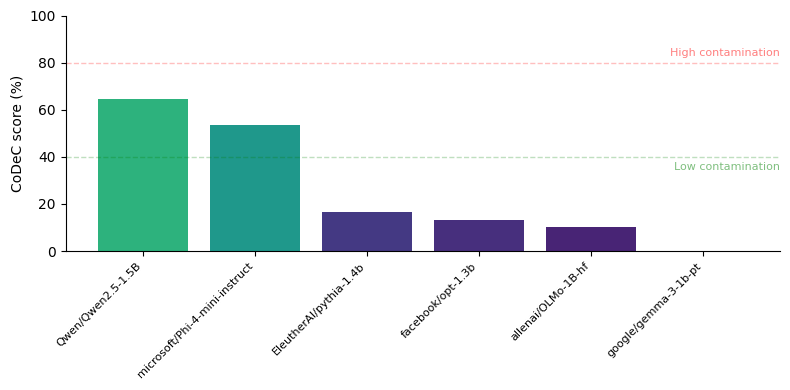

In [11]:
models_to_test = [
    "EleutherAI/pythia-1.4b",
    "allenai/OLMo-1B-hf",
    "facebook/opt-1.3b",
    "google/gemma-3-1b-pt",
    "Qwen/Qwen2.5-1.5B",
    "microsoft/Phi-4-mini-instruct",
]

verify_benchmark(load_aime_dataset("2024"), models_to_test)

## Finetuning

When a model is finetuned on a dataset, it becomes highly contaminated with it. This experiment can be run with any model, even if its training data is not publicly available.

Already after initial steps, CoDeC scores for the whole finetuning dataset approach 100%, even before the model has seen all samples.

CoDeC also captures the increase in contamination resulting from training on a related distribution.

In [14]:
def tokenize_function(tokenizer, examples):
    return tokenizer(examples["text"], truncation=False, padding=False)


def load_model(model_name):
    model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer


def run_finetuning(model_name, dataset, n_checkpoints=4):
    output_dir = "finetuning_results"
    os.makedirs(output_dir, exist_ok=True)

    train_dataset = Dataset.from_dict({"text": dataset})
    model, tokenizer = load_model(model_name)
    tokenized_train_dataset = train_dataset.map(
        lambda x: tokenize_function(tokenizer, x), batched=True
    ).with_format("torch", device="cuda")

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=1,
        per_device_train_batch_size=8,
        save_steps=int(len(tokenized_train_dataset) / 8 / n_checkpoints),
        save_total_limit=100,
        logging_steps=5,
        no_cuda=False,
        fp16=True,
        learning_rate=1e-5,
        seed=42,
        save_strategy="steps",
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer.save_model(output_dir=f"{output_dir}/checkpoint-0")
    trainer.train()

    print(f"Checkpoints saved to {output_dir}")

In [ ]:
def get_checkpoint_paths(output_dir="finetuning_results"):
    checkpoint_paths = []

    for checkpoint in [f for f in os.listdir(output_dir) if f.startswith("checkpoint")]:
        checkpoint_path = os.path.join(output_dir, checkpoint)
        checkpoint_num = int(re.search(r"checkpoint-(\d+)", checkpoint).group(1))
        checkpoint_name = f"checkpoint-{checkpoint_num:04d}"

        checkpoint_paths.append((checkpoint_name, checkpoint_path))

    return list(sorted(checkpoint_paths))


def evaluate_on_datasets(output_dir, datasets):
    scores = defaultdict(list)
    checkpoint_paths = get_checkpoint_paths(output_dir)

    for i, (checkpoint_name, checkpoint_path) in enumerate(checkpoint_paths):
        model_handler = ModelHandler(model_name=None, checkpoint_path=checkpoint_path)

        for dataset_name, dataset in datasets:
            result = contamination_detection_pipeline(
                model_handler, dataset, num_context_examples=1, max_dataset_size=1000
            )
            print(
                f"CoDeC contamination score ({checkpoint_name}, {dataset_name}): {result['overall_contamination_score']}"
            )
            scores[dataset_name].append(result["overall_contamination_score"])

    fig, ax = plt.subplots(figsize=(6, 4))

    for dataset_name, scores_vals in scores.items():
        ax.plot(
            range(len(scores_vals)),
            np.array(scores_vals) * 100,
            label=dataset_name,
            linewidth=3,
        )

    ax.set_xticks(range(len(checkpoint_paths)))
    ax.set_xticklabels(
        [int(path[0].split("-")[-1]) for path in checkpoint_paths], fontsize=8
    )
    ax.set_xlabel("Finetuning steps")
    ax.set_ylim(0, 100)
    ax.set_ylabel("CoDeC score (%)")

    # Remove the top and right border
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.0)

    plt.tight_layout()

In [16]:
run_finetuning("EleutherAI/pythia-410m", load_gsm8k_dataset(), n_checkpoints=4)

Map: 100%|██████████| 1319/1319 [00:00<00:00, 18982.46 examples/s]
/tmp/ipykernel_3806273/2874792061.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
5,2.741900
10,2.594500
15,2.344500
20,2.545900
25,2.426300
30,2.417000
35,2.456600
40,2.466400
45,2.353800
50,2.389200


Checkpoints saved to finetuning_results


Processing 100 samples...
CoDeC contamination score (checkpoint-0000, GSM8K (finetuned)): 0.06
Processing 100 samples...
CoDeC contamination score (checkpoint-0000, GPQA): 0.49
Processing 90 samples...
CoDeC contamination score (checkpoint-0000, AIME 2024): 0.14444444444444443
Processing 100 samples...
CoDeC contamination score (checkpoint-0041, GSM8K (finetuned)): 0.82
Processing 100 samples...
CoDeC contamination score (checkpoint-0041, GPQA): 0.68
Processing 90 samples...
CoDeC contamination score (checkpoint-0041, AIME 2024): 0.3
Processing 100 samples...
CoDeC contamination score (checkpoint-0082, GSM8K (finetuned)): 0.91
Processing 100 samples...
CoDeC contamination score (checkpoint-0082, GPQA): 0.67
Processing 90 samples...
CoDeC contamination score (checkpoint-0082, AIME 2024): 0.34444444444444444
Processing 100 samples...
CoDeC contamination score (checkpoint-0123, GSM8K (finetuned)): 0.95
Processing 100 samples...
CoDeC contamination score (checkpoint-0123, GPQA): 0.65
Proce

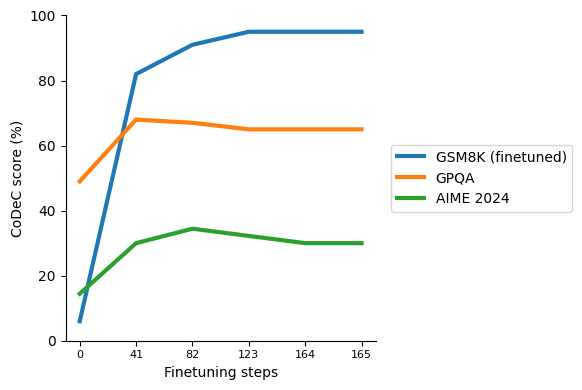

In [18]:
evaluate_on_datasets(
    "finetuning_results",
    [
        ("GSM8K (finetuned)", load_gsm8k_dataset()),
        ("GPQA", load_gpqa_dataset()),
        ("AIME 2024", load_aime_dataset("2024")),
    ],
)